## Django Dataset Exploration

In [27]:
import os
import random
from collections import namedtuple, Counter
import builtins

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from typing import Callable

# import nbimporter
# from utils_nb import get_all_words_pred

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
code_file = '../../raw-datasets/django/all.code'
anno_file = '../../raw-datasets/django/all.anno'

code_lines = [l.strip() for l in open(code_file, "rt").readlines()]
anno_lines = [l.strip() for l in open(anno_file, "rt").readlines()]

assert len(code_lines) == len(anno_lines)
print('dataset size:', len(code_lines))

df = pd.DataFrame({'anno': anno_lines, 'code': code_lines})

dataset size: 18805


In [6]:
a, c = df.iloc[np.random.randint(len(df))].values
print('>', a)
print('>', c)

> and fileobj set to zbuf.   call the method zfile.write with an argument s.
> zfile . write ( s )


### Vocabulary

In [7]:
PUNCTUATION = {
    'sep'   : u'\u200b' + "/-'´′‘…—−–",
    'keep'  : "&",
    'remove': '?!.,，"#$%\'()*+-/:;<=>@[\\]^_`{|}~“”’™•°'
}

def clean_text(x):
    x = x.lower()

    for p in PUNCTUATION['sep']:
        x = x.replace(p, " ")
    for p in PUNCTUATION['keep']:
        x = x.replace(p, " %s " % p)
    for p in PUNCTUATION['remove']:
        x = x.replace(p, "")

    return x

In [15]:
tokenizer = RegexpTokenizer(r'\w+')
anno_vocab = Counter()

for a in tqdm(anno_lines):
    toks = set(tokenizer.tokenize(a)) - stopWords
    for tok in toks:
        anno_vocab[tok.lower()] += 1

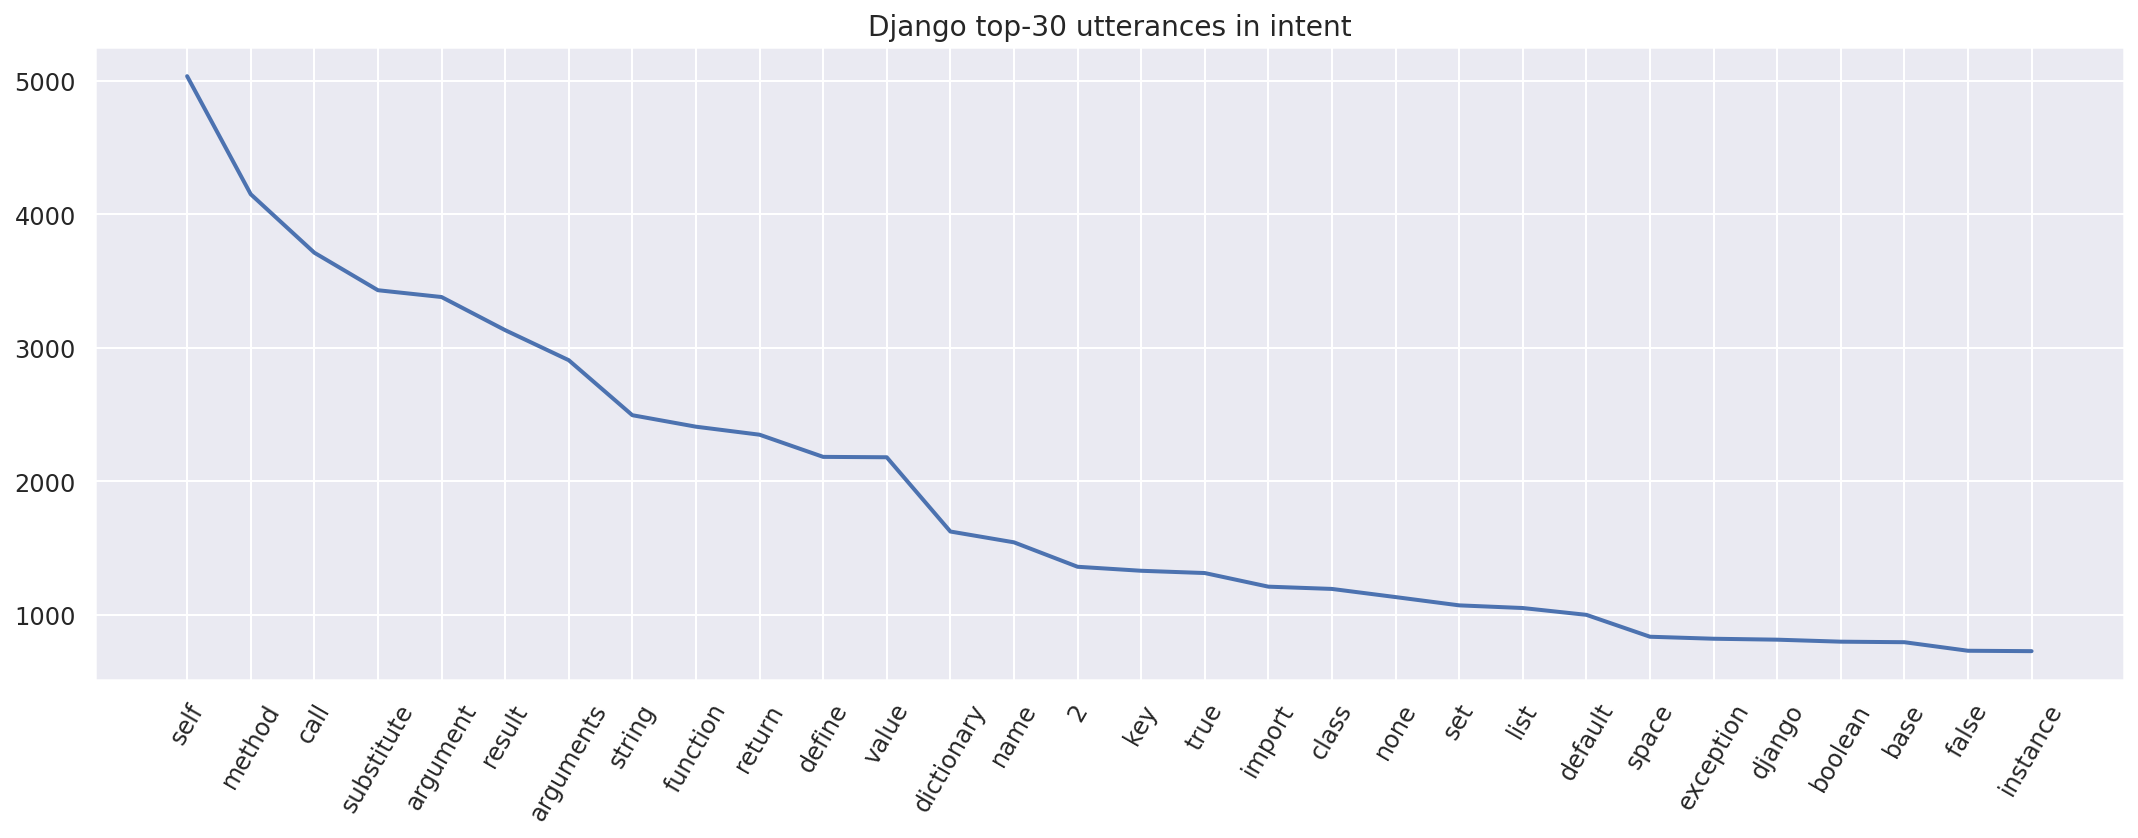

In [17]:
n = 30
words, counts = zip(*anno_vocab.most_common(n))

plt.figure(figsize=(int(0.5 * n), 6))
plt.xticks(range(len(words)), words, rotation=60, fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('symlog')
plt.plot(range(len(words)), counts, 'b-', linewidth=2)
plt.title('Django top-%d utterances in intent' % n, size=14)
plt.tight_layout()
plt.show()

## Hierarchical vocabulary

This might help overcome the high level of verbosity in the annotation vocabulary.
A hierarchical vocabulary follows the principle of sketch representations (i.e. abstract away the specifics).

**Level 1**
- Python reserved keywords
- class / variable names

In [30]:
RESERVED_KEYWORDS = set(dir(builtins) + [
    "and", "assert", "break", "class", "continue", "def", "del", "elif",
    "else", "except", "exec", "finally", "for", "from", "global", "if",
    "import", "in", "is", "lambda", "not", "or", "pass", "print", "raise",
    "return", "try", "while", "yield", "None", "self"
])  # len = 182

In [32]:
def find_tokens_by(main_vocab: Counter, criteria: Callable):
    return [(word, count) for (word, count) in main_vocab.items() if criteria(word)]

# find_tokens_by(anno_vocab, lambda w: w in RESERVED_KEYWORDS)

## Vocabulary coverage

In [ ]:
listing = [l.strip() for l in open('../../corpus/python-docs/listing.txt').readlines()]
all_words = Counter()

for l in tqdm(listing, desc="Get all words"):
    file_contents = [clean_text(l.strip().lower()) for l in open(l, "rt").readlines()]
    
    for line in file_contents:
        for w in line.split():
            if re.match(r'[\w]+', w) and w not in stopWords:
                all_words[w] += 1

In [ ]:
def get_vocab_coverage(data, vocab) -> (Counter, Counter):
    """
    How much of 'data' is in 'vocab'
    """
    
    oov = Counter() # out-of-vocab
    inv = Counter() # in-vocab
    oov_uniq_num = inv_uniq_num = 0.0
    oov_all_num = inv_all_num = 0.0
    
    for w in tqdm(data):
        if w in vocab:
            inv[w] = data[w]
            inv_uniq_num += 1
            inv_all_num += data[w]
        else:
            oov[w] = data[w]
            oov_uniq_num += 1
            oov_all_num += data[w]
    
    
    assert inv_all_num + oov_all_num == sum(data.values())
    
    cov_uniq = 100.0 * round(inv_uniq_num / len(data), 5)
    cov_all = 100.0 * round(inv_all_num / (inv_all_num + oov_all_num), 5)
    
    print("coverage (unique): %.3f%%" % cov_uniq)
    print("coverage (all text): %.3f%%" % cov_all)
    
    return oov, inv


oov, inv = get_vocab_coverage(anno_vocab, all_words)

'assign' in all_words

### Check intent-corpus coverage

In [ ]:
pt_emb = pickle.load(open('../../embeddings/glove.6B.200d.txt.pickle', 'rb'))

c = get_all_words_pred(
    corpus='../../corpus/python-stackoverflow/question_words_clean.pickle',
    vocab_size=8000,
    word_predicate=lambda w: w in pt_emb,
    min_freq=100, pt_emb=pt_emb
)

In [ ]:
# calculate coverage for all words in intents that are also present in embeddings (i.e. skip var names etc)

n = len(anno_vocab)
d = set(anno_vocab.keys()) - set(c.keys())
i = set(anno_vocab.keys()).intersection(set(c.keys()))

x = t = 0
ws = []

for w in anno_vocab:
    if w not in pt_emb: continue
    
    if w in c:
        x += 1
    else:
        ws += [w]
        
    t += 1
    
print("Intent-corpus coverage", round(x/t, 5))

ws[:10]